This notebook investigates possible approaches to reduce the dimensionality of the pulse temporal profile representation while maintaining the very same informative patrimony. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague


# Motivation

The temporal profile of the pulse is represented in a very highly dimensional way because of necessity related to FFT algorithm's resolution. However, it is certainly possible to compress its representation. 

In [1]:
import torch
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")
from utils.se import get_project_root
from algorithms.L1_BayesianOptimisation import extract_data
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
import numpy as np
from tqdm import tqdm
from torch.linalg import norm

frequency, field = extract_data()

The preprocessing steps do not depend on the control parameters, therefore they can take place even in numpy

In [2]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

However, to be used in the Computational Laser model, their tensor version is required

In [3]:
from utils.LaserModel_torch import ComputationalLaser as CL
from scipy.optimize import Bounds

intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)
compressor_params = -1 * torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)

laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)

bounds_control = Bounds(
                    # GDD         # TOD          # FOD
            lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
            ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds = torch.from_numpy(np.vstack((bounds_control.lb, bounds_control.ub)).T)

To study metrics that can help differentiate between pulses, here we consider the temporal profiles which are obtained using: 
1) The **mean control** with respect to the bounds considered
2) The control obtained applying what corresponds to the **lower bound** for the bounds considered
3) The control obtained applying what corresponds to the **upper bound** for the bounds considered

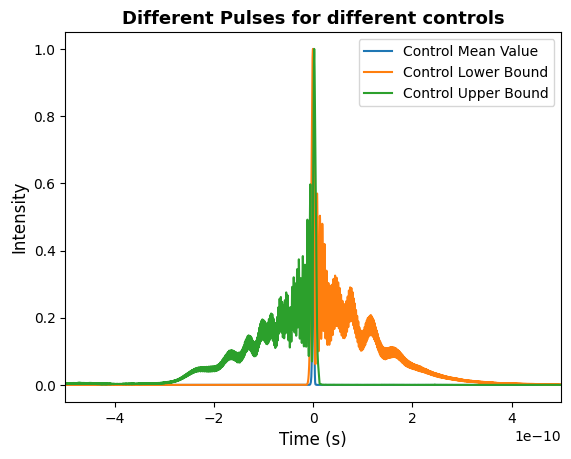

In [4]:
time_lb, profile_lb = laser.forward_pass(bounds[:,0])
time_mean, profile_mean = laser.forward_pass(bounds.mean(axis = 1))
time_ub, profile_ub = laser.forward_pass(bounds[:,1])

fig, ax = plt.subplots()
ax.plot(time_mean, profile_mean, label = "Control Mean Value")
ax.plot(time_lb, profile_lb, label = "Control Lower Bound")
ax.plot(time_ub, profile_ub, label = "Control Upper Bound")

ax.set_xlim(-5e-10, 5e-10)
ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.set_title("Different Pulses for different controls", fontweight = "bold", fontsize = 13)
ax.legend(fontsize = 10)

plt.show()

This very same representation can be represented once more without wasting all the memory that is needed to store long arrays such as these ones. 
In particular, the temporal profile can be condensed into a much more informative representation than the original one consisting of all the 33'000 points usually used.

A first approach could be the one of "cutting" the temporal profile into a region in which it is assuming values which are larger than a given threshold, thus reducing the dimensionality of the array representative of the pulse. 



However, such an approach would suffer from one major flaws: the number of elements in the cutted pulse **would depend on each single pulse**, thus generating a situation in which each single pulse is represented by an array with a different number of elements. The `min_thresh` value would influence very much the final shape, thus adding an additional hyperparameter to worry about.

Much more relevant to the analysis considered is the ability of embedding the pulse into a low-dimensional representation that would consist of a limited number of parameters characterizing the pulse itself. This notebook investigates which parameters have to be used.

# Pulse Embedding
This notebook explores a possible embedding for the considered pulse. Such an embedding can be used to condense information presented in the pulse shape into a much lower-dimensional representation.

## Peak Intensity (absolute values)
The output of the semiphysical model is always normalized in the 0-1 range. However, the phase-control parameters can be used also to modify the *absolute* value of such peak intensity. 
If one indicates with $I(t)$ the normalized intensity in its time domain representation, then the peak intensity $I_0$ can be obtained using the following relationship: 

$$
I_0 = \frac{2 E}{\pi w_0^2 \cdot \int_{-\infty}^{+\infty} \vert \mathcal{E}(t) \vert^2 dt}
$$

Which can be rewritten in light of the fact that $\int_{-\infty}^{+\infty} \vert \mathcal{E}(t) \vert^2 dt = \int_{-\infty}^{+\infty} I(t) dt$, since $\mathcal E (t)$ is nothing but the time representation of the electric field. Moreover, let: 

1) $w_0 = 12 [mm]$ be the **beam radius**, considered as a given parameter of the beam.

2) $E = 220 [mJ]$ be the **energy** of the beam, considered as a given parameter of the beam.

Under these assumptions, the peak intensity $I_0$ can be considered to equal to: 

$$
I_0 = \frac{2 E}{\pi w_0^2 \cdot \int_{-\infty}^{+\infty} I(t) dt}
$$

In [5]:
def peak_intensity(pulse_intensity:np.array, w0:float=12e-3, E:float=220e-3, dt:float=4.67e-14) -> float: 
    """
    This function computes the peak intensity given a pulse shape in the 0-1 range and parameters of the energy.
    
    Args:  
        pulse_intensity (np.array): array of intensities in a different range from the actual one given the arbitrary units of the intensity values.
        w0 (float, optional): beam radius of the beam (given in SI units), defaults to 12mm for L1 pump. Defaults to 12 mm. 
        E (float, optional): beam energy (given in SI units), defaults to 220 mJ for L1 pump. Defaults to 220 mJ.
        dt (float, optional): distance in time domain between sample points to approximate the intensity integral. Defaults to 4.67e-14 (s) for 33k elements time profile. 
    
    Returns: 
        float: peak intensity value.
    """
    # the integral of the intensity can be approximated from the area under the curve of the pulse.
    I_integral = np.trapz(y = pulse_intensity, dx = dt)
    return (2 * E) / (np.pi * (w0 ** 2) * I_integral)

The value of peak intensity can be used to differentiate between different pulses. Moreover, $I_0$ can be used to rescale the pulses themselves so as to confront the different pulses not only with respect to shape.  

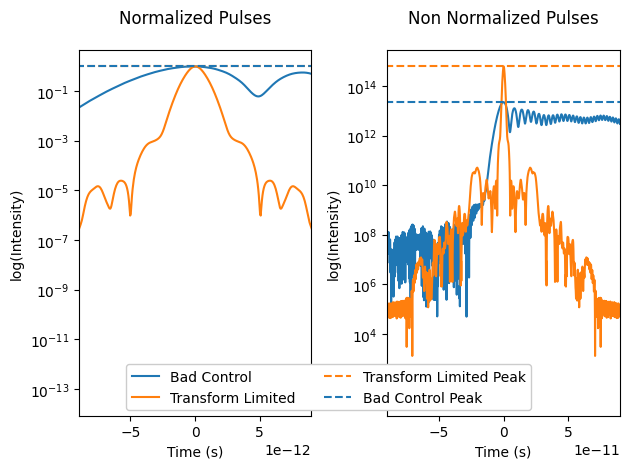

In [6]:
fig, ax = plt.subplots(ncols = 2)

time_TL, profile_TL = laser.transform_limited()

ax[0].plot(time_lb, np.roll(profile_lb, - np.argmax(profile_lb) + np.argmax(profile_TL.numpy())), label = "Bad Control", color = "tab:blue")
ax[0].plot(time_TL, profile_TL, label = "Transform Limited", color = "tab:orange")

ax[0].hlines(y = profile_TL.max(), xmin = time_lb.min(), xmax = time_lb.max(), label = "Transform Limited Peak", ls = "--", color = "tab:orange")
ax[0].hlines(y = profile_lb.max(), xmin = time_lb.min(), xmax = time_lb.max(), label = "Bad Control Peak", ls = "--", color = "tab:blue")

ax[0].set_xlim(-9e-12, 9e-12)
ax[0].set_yscale("log")
ax[0].set_title("Normalized Pulses", y = 1.05)
ax[0].set_xlabel("Time (s)"); ax[0].set_ylabel("log(Intensity)")


ax[1].plot(time_lb, np.roll(peak_intensity(profile_lb) * profile_lb, - np.argmax(profile_lb) + np.argmax(profile_TL.numpy())), label = "Bad Control", color = "tab:blue")
ax[1].plot(time_TL, peak_intensity(profile_TL) * profile_TL, label = "Transform Limited", color = "tab:orange")

ax[1].hlines(y = peak_intensity(profile_TL), xmin = time_lb.min(), xmax = time_lb.max(), label = "Transform Limited Peak", ls = "--", color = "tab:orange")
ax[1].hlines(y = peak_intensity(profile_lb), xmin = time_lb.min(), xmax = time_lb.max(), label = "Bad Control Peak", ls = "--", color = "tab:blue")

ax[1].set_xlim(-9e-11, 9e-11)
ax[1].set_yscale("log")
ax[1].set_title("Non Normalized Pulses", y = 1.05)
ax[1].set_xlabel("Time (s)"); ax[1].set_ylabel("log(Intensity)")


handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize = 10, ncol = 2, loc = (0.2, 0.125), framealpha = 1)

fig.tight_layout()

This visualisation shows how the value of $I_0$ can be effectively used to differentiate between non-normalized pulses given their 0-1 normalized version.

## FWHM
The value of the *full width half max* is another metric significant for the considered pulse. 
Since the $I_0$ scaling only impacts the magnitude but not the shape it is possible to retrieve such a value even for the normalized pulse. 

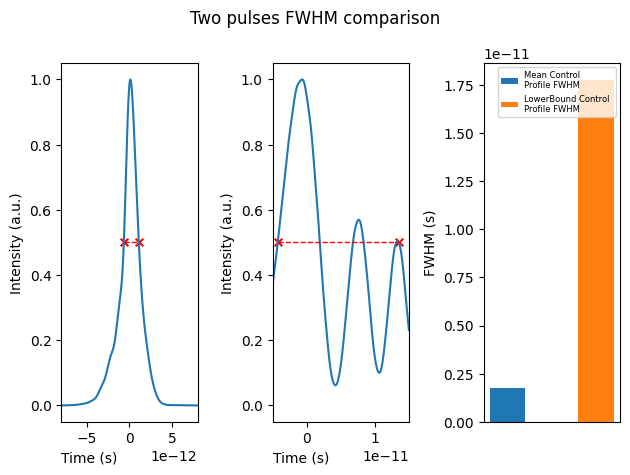

In [7]:
from matplotlib import ticker
import sys
sys.path.append("../..")
from utils.physics import FWHM

profile_MEAN_fwhm, mean_roots = FWHM(time_mean, profile_mean, return_roots=True)
profile_LB_fwhm, lb_roots = FWHM(time_lb, profile_lb, return_roots=True)

t1, t2 = mean_roots 
t11, t21 = lb_roots

y1, y2 = 0.5, 0.5

fig, ax = plt.subplots(ncols = 3)

ax[0].plot(time_mean, profile_mean)
ax[0].scatter(x = [t1, t2], y = [y1, y2], marker = "x", s = 30, c = "red")
ax[0].plot([t1, t2],[y1, y2], lw = 1, ls = "--", color = "red", label = "FWHM")
ax[0].set_xlim(-8e-12, 8e-12)
ax[0].set_xlabel("Time (s)", loc = "left"); ax[0].set_ylabel("Intensity (a.u.)")

ax[1].plot(time_lb, profile_lb)
ax[1].scatter(x = [t11, t21], y = [y1, y2], marker = "x", s = 30, c = "red")
ax[1].plot([t11, t21],[y1, y2], lw = 1, ls = "--", color = "red", label = "FWHM")
ax[1].set_xlim(-5e-12, 15e-12)
ax[1].set_xlabel("Time (s)", loc = "left"); ax[1].set_ylabel("Intensity (a.u.)")

ax[2].bar(x = [2], height = profile_MEAN_fwhm, label = "Mean Control \nProfile FWHM")
ax[2].bar(x = [4], height = profile_LB_fwhm, label = "LowerBound Control \nProfile FWHM")
ax[2].set_xticks(())
ax[2].legend(fontsize = 6)
ax[2].set_ylabel("FWHM (s)")

fig.suptitle("Two pulses FWHM comparison", fontsize = 12)
fig.tight_layout()

Once more, this visualization shows how the two different pulses can be described by different FWHM value.

More information can be gathered studying not only the FWHM but also other "widths" corresponding to 25% and 75% of the maximal value. This would essentially describe even further the pulse shape itself.

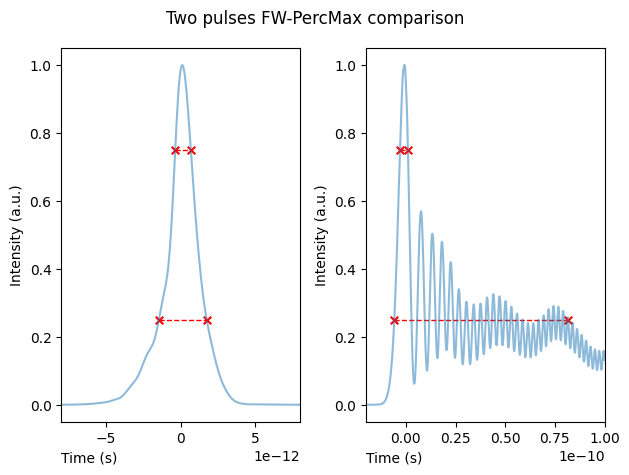

In [8]:
from utils.physics import FWPercM

profile_MEAN_25max, mean_roots_25max = FWPercM(time_mean, profile_mean, perc = .25, return_roots=True)
profile_LB_25max, lb_roots_25max = FWPercM(time_lb, profile_lb, perc = .25, return_roots=True)

t1_25, t2_25 = mean_roots_25max 
t11_25, t21_25 = lb_roots_25max
y1_25, y2_25 = .25, .25

profile_MEAN_75max, mean_roots_75max = FWPercM(time_mean, profile_mean, perc = .75, return_roots=True)
profile_LB_75max, lb_roots_75max = FWPercM(time_lb, profile_lb, perc = .75, return_roots=True)

t1_75, t2_75 = mean_roots_75max 
t11_75, t21_75 = lb_roots_75max
y1_75, y2_75 = .75, .75

profile_MEAN_75max, mean_roots_75max = FWPercM(time_mean, profile_mean, perc = .75, return_roots=True)
profile_LB_75max, lb_roots_75max = FWPercM(time_lb, profile_lb, perc = .75, return_roots=True)

fig, ax = plt.subplots(ncols = 2)

ax[0].plot(time_mean, profile_mean, alpha = .5)
ax[0].scatter(x = [t1_25, t2_25], y = [y1_25, y2_25], marker = "x", s = 30, c = "red")
ax[0].plot([t1_25, t2_25],[y1_25, y2_25], lw = 1, ls = "--", color = "red", label = "FullWidth-25%-Max")
ax[0].set_xlim(-8e-12, 8e-12)
ax[0].set_xlabel("Time (s)", loc = "left"); ax[0].set_ylabel("Intensity (a.u.)")

ax[0].scatter(x = [t1_75, t2_75], y = [y1_75, y2_75], marker = "x", s = 30, c = "red")
ax[0].plot([t1_75, t2_75],[y1_75, y2_75], lw = 1, ls = "--", color = "red", label = "FullWidth-75%-Max")

ax[1].plot(time_lb, profile_lb, alpha = .5)
ax[1].scatter(x = [t11_25, t21_25], y = [y1_25, y2_25], marker = "x", s = 30, c = "red")
ax[1].plot([t11_25, t21_25],[y1_25, y2_25], lw = 1, ls = "--", color = "red", label = "FullWidth-25%-Max", zorder = 1)
ax[1].set_xlim(-20e-12, 100e-12)
ax[1].set_xlabel("Time (s)", loc = "left"); ax[1].set_ylabel("Intensity (a.u.)")

ax[1].scatter(x = [t11_75, t21_75], y = [y1_75, y2_75], marker = "x", s = 30, c = "red")
ax[1].plot([t11_75, t21_75],[y1_75, y2_75], lw = 1, ls = "--", color = "red", label = "FullWidth-75%-Max", zorder = 1)

fig.suptitle("Two pulses FW-PercMax comparison", fontsize = 12)
fig.tight_layout()

## (Normalized Pulse) Energy
Normalized Pulses are different one from each other also for what concerns the value of the area under the pulse itself.

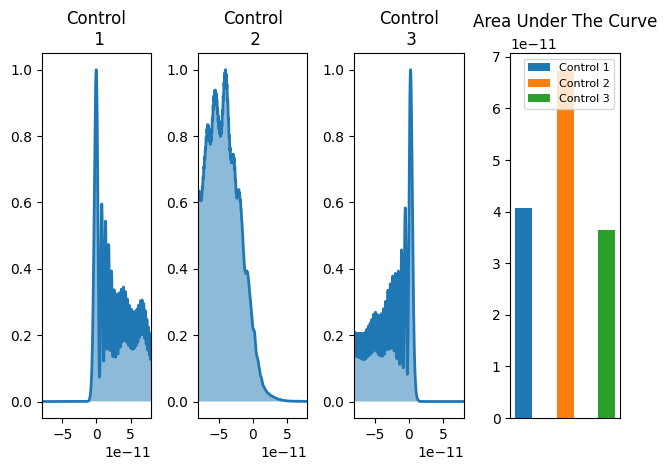

In [9]:
# randomly controls between the bounds to compare the different pulses
ncontrols = 3
torch.manual_seed(42)
controls = torch.distributions.Uniform(low = bounds[:,0], high = bounds[:,1]).sample((ncontrols,))

pulses = {
    key: (laser.forward_pass(key)) for key in controls
}
i = 1
fig, ax = plt.subplots(ncols = ncontrols + 1)
for (time, pulse) in pulses.values(): 
    ax[i-1].plot(time, pulse, label = f"Control {i}", lw = 2)
    ax[i-1].set_title(f"Control\n {i}")
    ax[i-1].fill(time, pulse, alpha = .5)
    ax[i-1].set_xlim(-8e-11, 8e-11)
    i += 1

for j in range(ncontrols): 
    time, pulse = list(pulses.values())[j]
    ax[-1].bar(x = [1 + 2*j], height = np.trapz(y = pulse, dx = np.abs(np.diff(time)[0])), label = f"Control {j+1}")
    ax[-1].set_xticks([])
    ax[-1].set_title("Area Under The Curve", y = 1.05)

ax[-1].legend(fontsize = 8)
fig.tight_layout()

These three completely different pulses do have completely different values of areas, as shown in the previous visualization in which the pulse obtained with "Control 2" subtends an area much larger than the one subtended by the other two pulses. 

## (Normalized Pulses) Top & Bottom Area
The relationship between the area subtended by the suportion of the pulse that is above the FWHM and the one below FWHM is crucial to take into account wings whose oscillation does not reach the FWHM value. 

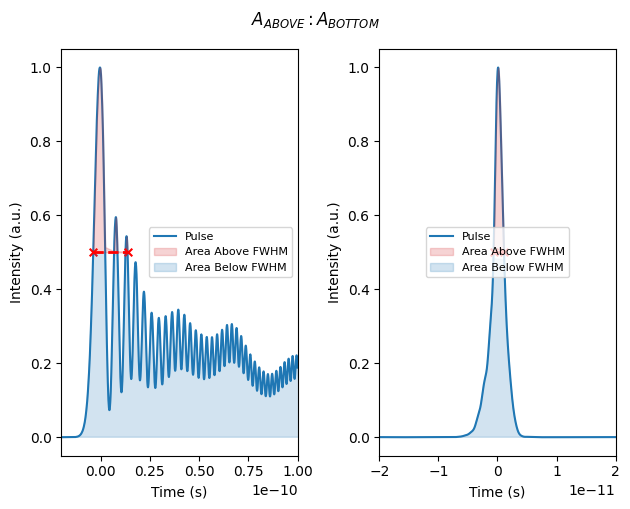

In [10]:
time1, pulse1 = list(pulses.values())[0]

FWHM_control1, roots1 = FWHM(time1, pulse1, return_roots=True)
FWHM_mean, roots_mean = FWHM(time_mean, profile_mean, return_roots=True)

pulse_mean_mask = (time_mean >= roots1[0]) & (time_mean <= roots1[-1]) & (profile_mean >= 0.5)
pulse1_mask = (time1 >= roots1[0]) & (time1 <= roots1[-1]) & (pulse1 >= 0.5)

fig, ax = plt.subplots(ncols = 2)

ax[0].plot(time1, pulse1, zorder = -1, label = "Pulse")
ax[0].scatter(x = roots1, y = [0.5, 0.5], marker = "x", s = 30, c = "red")

ax[0].fill_between(x = time1[pulse1_mask], y1 = pulse1[pulse1_mask], y2 = 0.5 * np.ones_like(pulse1[pulse1_mask]), color = "tab:red", alpha = .2, label = "Area Above FWHM")
ax[0].fill_between(x = time1[~pulse1_mask], y1 = pulse1[~pulse1_mask], y2 = 0, color = "tab:blue", alpha = .2, label = "Area Below FWHM")

ax[0].plot(roots1, [0.5, 0.5], ls = "--", lw = 2, c = "red", zorder = 1)
ax[0].legend(fontsize = 8, loc = "center right")

ax[0].set_xlabel("Time (s)"); ax[0].set_ylabel("Intensity (a.u.)")
ax[0].set_xlim(-2e-11, 1e-10)


ax[1].plot(time_mean, profile_mean, zorder = -1, label = "Pulse")
ax[1].scatter(x = roots_mean, y = [0.5, 0.5], marker = "x", s = 30, c = "red")

ax[1].fill_between(x = time_mean[pulse_mean_mask], y1 = profile_mean[pulse_mean_mask], y2 = 0.5 * np.ones_like(profile_mean[pulse_mean_mask]), color = "tab:red", alpha = .2, label = "Area Above FWHM")
ax[1].fill_between(x = time_mean[~pulse_mean_mask], y1 = profile_mean[~pulse_mean_mask], y2 = 0, color = "tab:blue", alpha = .2, label = "Area Below FWHM")

ax[1].plot(roots_mean, [0.5, 0.5], ls = "--", lw = 2, c = "red", zorder = 1)
ax[1].legend(fontsize = 8, loc = "center")

ax[1].set_xlabel("Time (s)"); ax[1].set_ylabel("Intensity (a.u.)")
ax[1].set_xlim(-2e-11, 2e-11)

fig.tight_layout()
fig.suptitle(r"$A_{ABOVE} : A_{BOTTOM}$", y = 1.05) 
plt.show()

This visualization confirms that different pulses do have different values of $A_{ABOVE}$ and $A_{BOTTOM}$. As a qualitative assessment, the smaller the quantity $\frac{A_{ABOVE}}{A_{BOTTOM}}$ the worse the pulse is getting in terms of the presence of wings, for example.

## Build-Up duration
FWHM by itself might not be a metric which is representative of the pulse duration. The "build-up" (defined as the distance in time between the first and the last moment in which the intensity gets significantly larger than zero) can be used to furthermore describe the temporal appearance of the pulse itself.

In [11]:
def buildup(time:np.array, intensity:np.array, return_instants=False, min_thresh:float=1e-3) -> Union[float, Tuple[float, float]]: 
    """This function computes the buildup instants for the given signal.

    Args:
        time (np.array): Time Axis for the representation of the signal
        intensity (np.array): Intensity signal depending on time. 
        return_instants (bool, optional): whether to return or not return the first and last instant of the build-up.
        min_thresh (float, optional): Threshold below which each intensity value is equal to 0. 

    Returns:
        Union[float, Tuple[float, float]]: value, in seconds, of build duration and, optionally, the first and last instant 
        in which such condition is verified.
    """
    above_mask = intensity > min_thresh
    first_instant, last_instant = time[above_mask][0], time[above_mask][-1]
    buildup_duration = np.abs(np.array((first_instant, last_instant))).sum()
    if return_instants: 
        return buildup_duration, (first_instant, last_instant)
    else: 
        return buildup_duration

The same randomly generated pulses of before can be analysed now for what concerns the value of their build-up. 

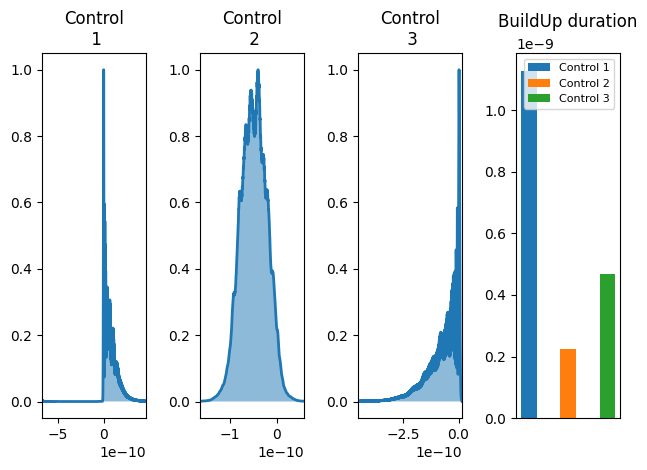

In [12]:
fig, ax = plt.subplots(ncols = ncontrols + 1)
i = 1
for (time, pulse) in pulses.values(): 
    ax[i-1].plot(time, pulse, label = f"Control {i}", lw = 2)
    ax[i-1].set_title(f"Control\n {i}")
    ax[i-1].fill(time, pulse, alpha = .5)
    ax[i-1].set_xlim(buildup(time, pulse, return_instants=True)[1])
    i += 1

for j in range(ncontrols): 
    time, pulse = list(pulses.values())[j]
    ax[-1].bar(x = [1 + 2*j], height = buildup(time = time, intensity = pulse), label = f"Control {j+1}")
    ax[-1].set_xticks([])
    ax[-1].set_title("BuildUp duration", y = 1.05)

ax[-1].legend(fontsize = 8)
fig.tight_layout()

This shows that also the build up duration can be used to discriminate between the different pulses. 

## Conclusions
This analysis has been carried out with the scope of elaborating and testing our hypothesis on the possibility of using derived metrics to describe the pulse temporal profile using a representation of a much reduced dimensionality than the one of the pulse itself.
This analysis ends with the elaboration of the `PulseEmbedding` class. 

In [18]:
class PulseEmbedding: 
    def __init__(self, w0:float=12e-3, E:float=220e-3, min_thresh:float=1e-3) -> None: 
        """Init function. 
        
        Args: 
            w0 (float, optional): beam radius of the beam (given in SI units), defaults to 12mm for L1 pump. Defaults to 12 mm. 
            E (float, optional): beam energy (given in SI units), defaults to 220 mJ for L1 pump. Defaults to 220 mJ.
            min_thresh (float, optional): Threshold below which each intensity value is equal to 0. 
        
        Returns: 
            None
        """
        self.w0 = w0
        self.E = E
        self.min_thresh = min_thresh
    
    def embed(self, time:np.array, pulse:np.array) -> np.array: 
        """Embedding function mapping the pulse to a lower dimensional representation. 
        
        Args: 
            time (np.array): Time array in which each element is a sample moment of the pulse. Zero on the peak of the pulse according
            to fftshift. 
            pulse (np.array): Array representing the temporal profile of the pulse in the 0-1 range.
        
        Returns: 
            np.array: Pulse, embedded.
        """
        dx = np.abs(np.diff(time)[0])
        
        I_0 = peak_intensity(pulse_intensity=pulse, w0 = self.w0, E = self.E, dt = dx)
        FWHM_value, roots = FWHM(x = time, y = pulse, return_roots = True)
        root1, root2 = roots
        
        FW25M, roots25 = FWPercM(x = time, y = pulse, perc = .25, return_roots = True)
        root1_25, root2_25 = roots25
        
        FW75M, roots75 = FWPercM(x = time, y = pulse, perc = .75, return_roots = True)
        root1_75, root2_75 = roots75
        
        top_mask = (time >= root1) & (time <= root1) & (pulse >= 0.5)
        bottom_mask = ~top_mask
        
        A_total = np.trapz(y = pulse, dx = dx)
        A_top = np.trapz(np.clip(pulse - 0.5, a_min = 0, a_max = None), dx = dx)
        A_bottom = A_total - A_top
        
        buildup_duration, istants = buildup(time = time, intensity = pulse, return_instants = True, min_thresh = self.min_thresh)
        inst1, inst2 = istants
        
        return np.array((I_0, FWHM_value, root1, root2, FW25M, root1_25, root2_25, FW75M, root1_75, root2_75, A_total, A_top, A_bottom, buildup_duration, inst1, inst2))
    
    def embed_Series(self, time:np.array, pulse:np.array) -> pd.Series: 
        """This function embeds a pulse in a Series for code readibility"""
        embedded = self.embed(time=time, pulse=pulse)
        embedded_Series = pd.Series(data = embedded,
                                  index = [
                                      "Peak Intensity",
                                      "FWHM", 
                                      "FWHM_left", "FWHM_right",
                                      "FW25M", 
                                      "FW25M_left", "FW25M_right",
                                      "FW75M", 
                                      "FW75M_left", "FW75M_right",
                                      "Total Area", 
                                      "Area Under FWHM",
                                      "Area Above FWHM", 
                                      "Buildup duration", 
                                      "Buildup_left", "Buildup_right"
                                      ]
                                 )
        return embedded_Series

This very same class can be found in `utils/physics` and all it does is that it embeds the pulse into a 10-dimensional vector that tries to capture some of the informative patrimony of the pulse itself. This embedding can most likely be used as state ($s_t$) in RL, but its application is also related to other fields such as numerical optimization. 

In [19]:
pe = PulseEmbedding()
pe.embed_Series(*list(pulses.values())[0])

Peak Intensity      2.386061e+13
FWHM                1.744161e-11
FWHM_left          -3.781480e-12
FWHM_right          1.366013e-11
FW25M               7.702017e-11
FW25M_left         -5.276056e-12
FW25M_right         7.174412e-11
FW75M               3.985099e-12
FW75M_left         -2.527611e-12
FW75M_right         1.457488e-12
Total Area          4.076231e-11
Area Under FWHM     2.057001e-12
Area Above FWHM     3.870531e-11
Buildup duration    1.129205e-09
Buildup_left       -6.735566e-10
Buildup_right       4.556488e-10
dtype: float64